# XGBoost

## Preprocessing

- Implement Log returns calculation
- Normalize or scale key features
- Encode log return to binary value (one-hot encoding)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, 
                            confusion_matrix, roc_auc_score,
                            RocCurveDisplay)

df = pd.read_csv("./filtered_stocks_combined.csv")

# Change Date to DateTime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['ticker', 'Date'])

# Create target variable
# 1 if current close > prev close, else 0
df['prev_close'] = df.groupby('ticker')['Close'].shift(1)
df['target'] = (df['Close'] > df['prev_close']).astype(int)
df = df.dropna(subset=['prev_close'])

In [2]:
df.head()

Date  index    Open    High     Low   Close     Volume  OpenInt  \
1 2011-01-04  45726  42.579  42.579  42.023  42.426   86135637        0   
2 2011-01-05  45727  42.260  42.817  42.196  42.772   70669988        0   
3 2011-01-06  45728  42.902  42.932  42.632  42.739   83619699        0   
4 2011-01-07  45729  42.787  43.073  42.503  43.045   86506108        0   
5 2011-01-10  45730  43.393  43.956  43.179  43.855  124888228        0   

  ticker  prev_close  target  
1   AAPL      42.204       1  
2   AAPL      42.426       1  
3   AAPL      42.772       0  
4   AAPL      42.739       1  
5   AAPL      43.045       1

## Split df into training/test set

In [3]:
features = ['Open', 'High', 'Low', 'Volume']
X = df[features]
y = df['target']
groups = df['ticker']

# Split off 80:20 for train:test
splitter = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=df['ticker']))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Hyperparameter Tuning

In [4]:
clf = xgb.XGBClassifier(
    objective='binary:logistic',
    booster='gbtree',     
    tree_method='hist',
    device='cuda',
    random_state=42,
    eval_metric='auc',
    n_jobs=1
)

### RandomizedSearchCV

In [5]:
rs_params = {
    "learning_rate":    [0.01, 0.03, 0.05, 0.1, 0.2, 0.3],
    "max_depth":        [3, 4, 5, 6, 8, 10, 12],
    "min_child_weight": [1, 2, 3, 5, 7, 10],
    "gamma":            [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "subsample":        [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "reg_alpha":        [0, 0.001, 0.01, 0.1, 1],
    "reg_lambda":       [0.5, 1, 1.5, 2, 5],
}

random_search = RandomizedSearchCV(
    clf,
    param_distributions=rs_params,
    n_iter=20,
    scoring='roc_auc',
    cv=5,
    verbose=2
)

random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\ProgramData\anaconda3\envs\cs3244\Lib\site-packages\xgboost\core.py:729: UserWarning: [04:30:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.03, max_depth=3, min_child_weight=7, reg_alpha=0.1, reg_lambda=1.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.03, max_depth=3, min_child_weight=7, reg_alpha=0.1, reg_lambda=1.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.03, max_depth=3, min_child_weight=7, reg_alpha=0.1, reg_lambda=1.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.03, max_depth=3, min_child_weight=7, reg_alpha=0.1, reg_lambda=1.5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.03, max_depth=3, min_child_weight=7, reg_alpha=0.1, reg_lambda=1.5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.3, max_depth=5, min_child_weight=5, reg_alpha=0.01, reg_lambda=5, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.3, 

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_co...
                                           num_parallel_tree=None, ...),
                   n_iter=20,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.01, 0.03, 0.05, 0.1,
                                                          0.2, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12],
                                        'min_child_weight': [1, 2, 3, 5, 7, 10],
                                        'reg_alpha': [0, 0.001, 0.01, 0.1, 1],
                                        'reg_lambda': [0.5, 1, 1.5, 2, 5],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   scoring='roc_auc', verbose=2)

In [6]:
random_search.best_estimator_
random_search.best_params_

{'subsample': 0.7,
 'reg_lambda': 5,
 'reg_alpha': 0,
 'min_child_weight': 2,
 'max_depth': 8,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'colsample_bytree': 1.0}

### GridSearchCV

In [7]:
best_rs_params = random_search.best_params_

gs_params = {
    "learning_rate": [
        max(0.01, best_rs_params["learning_rate"] * 0.5),
        best_rs_params["learning_rate"],
        min(0.3,  best_rs_params["learning_rate"] * 1.5)
    ],

    "max_depth": sorted(list(set([
        max(1, best_rs_params["max_depth"] - 1),
        best_rs_params["max_depth"],
        best_rs_params["max_depth"] + 1
    ]))),

    "min_child_weight": sorted(list(set([
        max(1, best_rs_params["min_child_weight"] - 1),
        best_rs_params["min_child_weight"],
        best_rs_params["min_child_weight"] + 1
    ]))),

    "gamma": [
        max(0.0, best_rs_params["gamma"] - 0.1),
        best_rs_params["gamma"],
        best_rs_params["gamma"] + 0.1
    ],

    "subsample": [
        max(0.5, best_rs_params["subsample"] - 0.1),
        best_rs_params["subsample"],
        min(1.0, best_rs_params["subsample"] + 0.1)
    ],
    "colsample_bytree": [
        max(0.5, best_rs_params["colsample_bytree"] - 0.1),
        best_rs_params["colsample_bytree"],
        min(1.0, best_rs_params["colsample_bytree"] + 0.1)
    ],

    "reg_alpha": [
        max(0.0, best_rs_params["reg_alpha"] / 2),
        best_rs_params["reg_alpha"],
        best_rs_params["reg_alpha"] * 2
    ],
    "reg_lambda": [
        max(0.1, best_rs_params["reg_lambda"] / 2),
        best_rs_params["reg_lambda"],
        best_rs_params["reg_lambda"] * 2
    ]
}

grid_search = GridSearchCV(
    clf,
    param_grid=gs_params,
    scoring='roc_auc', 
    cv=5,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 6561 candidates, totalling 32805 fits
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, reg_alpha=0.0, reg_lambda=2.5, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, reg_alpha=0.0, reg_lambda=2.5, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, reg_alpha=0.0, reg_lambda=2.5, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, reg_alpha=0.0, reg_lambda=2.5, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, reg_alpha=0.0, reg_lambda=2.5, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, reg_alpha=0.0, reg_lambda=2.5, subsample=0.7;

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='cuda',
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constrai...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=1, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.9, 1.0, 1.0],
                         'gamma': [0.1, 0.2, 0.30000000000000004],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [7, 8, 9], 'min_child_weight': [1, 2, 3],
                         'reg_alpha': [0.0, 0, 0], 'reg_lambda': [2.5, 5, 10],
                         'subsample': [0.6, 0.7, 0.7999999999999999]},
             scoring='roc_auc', verbose=2)

In [8]:
grid_search.best_estimator_
grid_search.best_params_

{'colsample_bytree': 1.0,
 'gamma': 0.30000000000000004,
 'learning_rate': 0.3,
 'max_depth': 9,
 'min_child_weight': 2,
 'reg_alpha': 0.0,
 'reg_lambda': 10,
 'subsample': 0.7999999999999999}

## Final Fit

Accuracy: 0.6419
F1 Score: 0.6734
AUC-ROC Score: 0.7047

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down            4114          3216
Actual Up              2188          5572


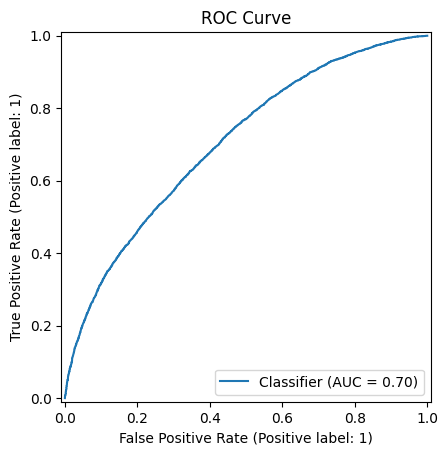

In [9]:
best_model = grid_search.best_estimator_

y_pred   = best_model.predict(X_test_scaled)
y_proba  = best_model.predict_proba(X_test_scaled)[:, 1]

acc      = accuracy_score(y_test, y_pred)
f1       = f1_score(y_test, y_pred)
roc_auc  = roc_auc_score(y_test, y_proba)
cm       = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC Score: {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, 
                  index=['Actual Down', 'Actual Up'],
                  columns=['Predicted Down', 'Predicted Up']))

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
plt.show()

## Inclusion of Rolling Window, Model Retrained Yearly

Rolling Window Sizes = 1, 5, 10, 20, 25, 60, 126

In [35]:
from sklearn.model_selection import TimeSeriesSplit

# Load and prepare data
df = pd.read_csv("./filtered_stocks_combined.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Date', 'ticker']).reset_index(drop=True)

# Create target variable (1 if current close > previous close)
df['prev_close'] = df.groupby('ticker')['Close'].shift(1)
df['target'] = (df['Close'] > df['prev_close']).astype(int)
df = df.dropna(subset=['prev_close']).reset_index(drop=True)

features = ['Open', 'High', 'Low', 'Volume']

# Split into train and test, maintaining temporal consistency
n_total = len(df)
train_size = int(0.8 * n_total)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:].copy()

# Add year column for grouping
test_df['Year'] = test_df['Date'].dt.year
unique_years = sorted(test_df['Year'].unique())

### Training

Rolling Window (1 Days)
Accuracy: 0.6327 | F1 Score: 0.6647 | AUC-ROC: 0.6887

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down            4054          3240
Actual Up              2302          5494


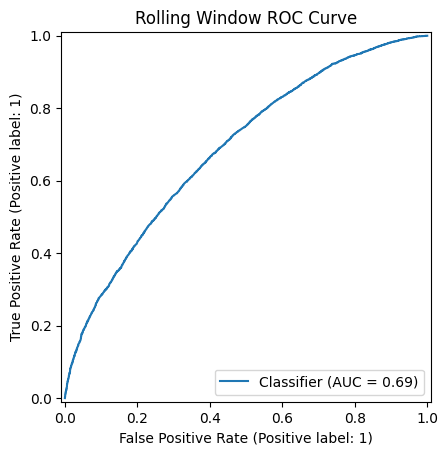

Rolling Window (5 Days)
Accuracy: 0.6327 | F1 Score: 0.6647 | AUC-ROC: 0.6887

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down            4054          3240
Actual Up              2302          5494


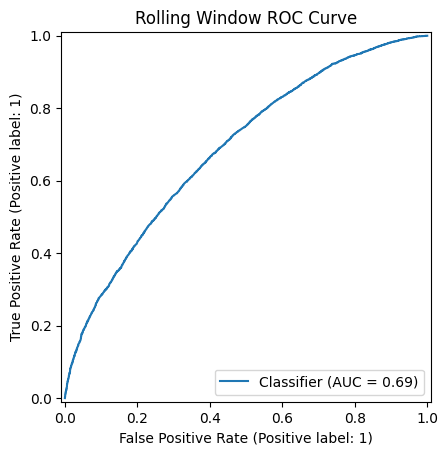

Rolling Window (10 Days)
Accuracy: 0.6327 | F1 Score: 0.6647 | AUC-ROC: 0.6887

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down            4054          3240
Actual Up              2302          5494


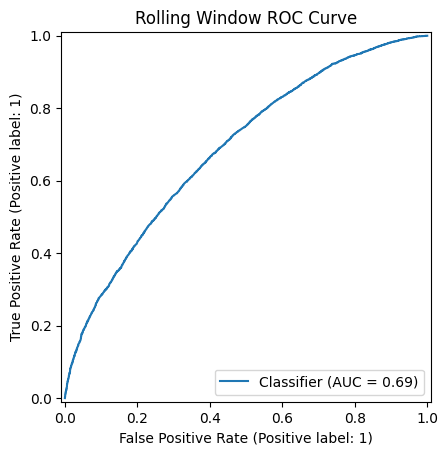

Rolling Window (20 Days)
Accuracy: 0.6328 | F1 Score: 0.6649 | AUC-ROC: 0.6888

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down            4048          3236
Actual Up              2302          5494


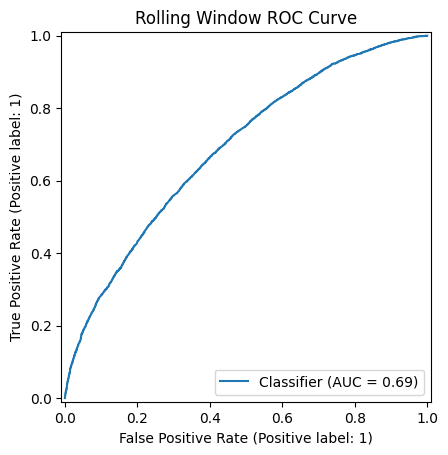

Rolling Window (25 Days)
Accuracy: 0.6328 | F1 Score: 0.6650 | AUC-ROC: 0.6888

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down            4045          3234
Actual Up              2302          5494


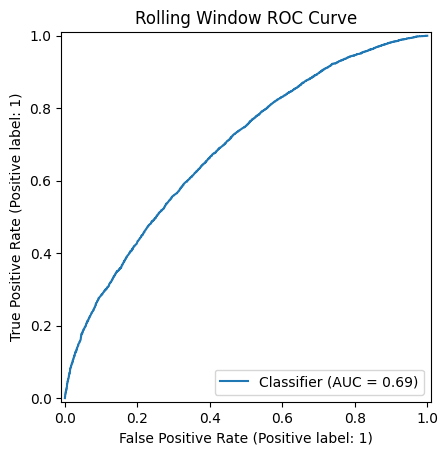

Rolling Window (60 Days)
Accuracy: 0.6329 | F1 Score: 0.6653 | AUC-ROC: 0.6888

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down            4037          3227
Actual Up              2302          5494


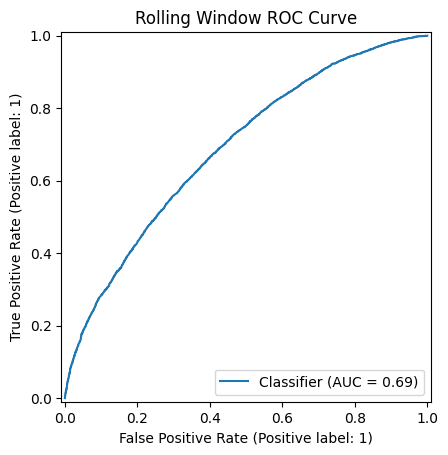

Rolling Window (126 Days)
Accuracy: 0.6337 | F1 Score: 0.6667 | AUC-ROC: 0.6895

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down            4010          3191
Actual Up              2301          5492


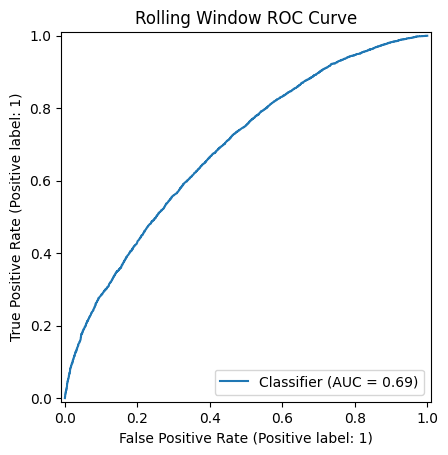

In [38]:
def make_narrow_distributions(best):
    return {
        "learning_rate":    [max(0.001, best["learning_rate"] * f) for f in (0.8, 1.0, 1.2)],
        "max_depth":        sorted({max(1, best["max_depth"] - 1), best["max_depth"], best["max_depth"] + 1}),
        "min_child_weight": sorted({max(1, best["min_child_weight"] - 1), best["min_child_weight"], best["min_child_weight"] + 1}),
        "gamma":            [max(0.0, best["gamma"] - 0.1), best["gamma"], best["gamma"] + 0.1],
        "subsample":        [max(0.5, best["subsample"] - 0.1), best["subsample"], min(1.0, best["subsample"] + 0.1)],
        "colsample_bytree": [max(0.5, best["colsample_bytree"] - 0.1), best["colsample_bytree"], min(1.0, best["colsample_bytree"] + 0.1)],
        "reg_alpha":        [best["reg_alpha"] * f for f in (0.5, 1.0, 2.0)],
        "reg_lambda":       [best["reg_lambda"] * f for f in (0.5, 1.0, 2.0)],
    }

best_gs_params = grid_search.best_params_

for window_size in [1, 5, 10, 20, 25, 60, 126]:
    # print(f"Current Window Size: {window_size}")

    tscv = TimeSeriesSplit(n_splits=5)

    all_y_true = []
    all_y_pred = []
    all_y_proba = []
    all_test_dates = []

    for idx, year in enumerate(unique_years):
        year_mask = test_df['Year'] == year
        year_test = test_df[year_mask].reset_index(drop=True)
        if idx == 0:
            year_train = train_df.copy()
        else:
            cutoff_date = year_test['Date'].min()
            up_to_year = df[df['Date'] < cutoff_date]
            year_train_size = int(0.8 * len(up_to_year))
            year_train = up_to_year.iloc[:year_train_size]

        scaler = StandardScaler()
        X_tr = scaler.fit_transform(year_train[features])
        y_tr = year_train['target'].values

        narrow_params = make_narrow_distributions(best_gs_params)
        year_search = RandomizedSearchCV(
            clf,
            param_distributions=narrow_params,
            n_iter=20,
            scoring='roc_auc',
            cv=tscv,
            n_jobs=1,
            verbose=0,
            random_state=42
        )

        year_search.fit(X_tr, y_tr)
        rolling_clf = year_search.best_estimator_

        test_size = window_size
        n_test    = len(year_test)
        for start in range(0, n_test - test_size + 1, test_size):
            batch = year_test.iloc[start : start + test_size]
            X_bt = scaler.transform(batch[features])
            y_bt = batch['target'].values

            y_pred_batch  = rolling_clf.predict(X_bt)
            y_proba_batch = rolling_clf.predict_proba(X_bt)[:, 1]

            all_y_true.extend(y_bt.tolist())
            all_y_pred.extend(y_pred_batch.tolist())
            all_y_proba.extend(y_proba_batch.tolist())
            all_test_dates.extend(batch['Date'].tolist())

    accuracy = accuracy_score(all_y_true, all_y_pred)
    f1 = f1_score(all_y_true, all_y_pred)
    auc = roc_auc_score(all_y_true, all_y_proba)
    cm = confusion_matrix(all_y_true, all_y_pred)

    print(f"Rolling Window ({window_size} Days)")
    print(f"Accuracy: {accuracy:.4f} | F1 Score: {f1:.4f} | AUC-ROC: {auc:.4f}")
    print("\nConfusion Matrix:")
    print(pd.DataFrame(cm, 
                    index=['Actual Down', 'Actual Up'],
                    columns=['Predicted Down', 'Predicted Up']))

    RocCurveDisplay.from_predictions(all_y_true, all_y_proba)
    plt.title('Rolling Window ROC Curve')
    plt.show()